# 2次元混合ガウス + ノイズ後サンプル可視化

このノートブックでは、下記の手順で可視化を行います。

1. **2次元混合ガウス分布**を用意
2. **100個サンプリング**して元の訓練データとする
3. **各サンプルに対してガウスノイズを100個**ずつ付加 (計10,000サンプル)
   - このとき、ノイズ後サンプルと元の点との対応関係を保持
4. **ノイズ後データ空間で特定のピクセル(矩形領域)を指定**し、
   そこに含まれるノイズ後サンプルが元々どの点に対応しているかを
   密度(ヒートマップ)で表示


## 1. ライブラリのインポート

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


## 2. 2次元混合ガウス分布の定義とサンプリング関数

In [4]:
def sample_mixture_gaussians(num_samples, mixing_coeffs, means, covs):
    """\n
    指定された混合ガウス分布から num_samples 個のサンプルを生成して返す関数\n
    mixing_coeffs: 混合係数のリスト (例: [0.5, 0.5])\n
    means: 各成分ガウスの平均リスト (例: [mean1, mean2])\n
    covs: 各成分ガウスの共分散行列リスト (例: [cov1, cov2])\n
    """
    samples = []
    n_components = len(mixing_coeffs)
    # どのコンポーネントからサンプリングするかを確率的に決定
    component_indices = np.random.choice(
        n_components, size=num_samples, p=mixing_coeffs
    )
    for c in component_indices:
        m = means[c]
        c_ = covs[c]
        s = np.random.multivariate_normal(m, c_, 1)
        samples.append(s)
    return np.vstack(samples)


### 混合ガウス分布のパラメータ設定 & サンプル生成

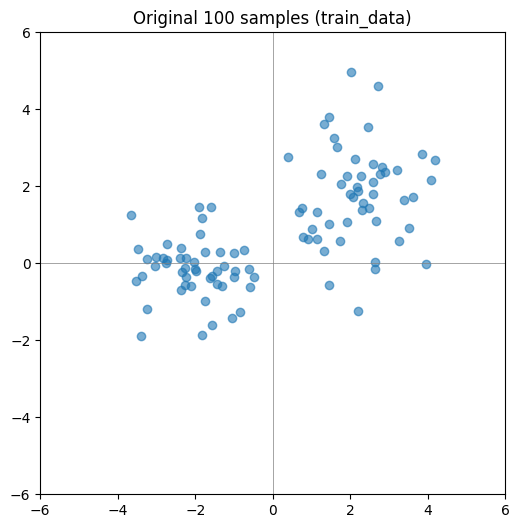

train_data.shape = (100, 2)


In [5]:
np.random.seed(123)

# 混合ガウスのパラメータ定義
mixing_coeffs = [0.5, 0.5]
means = [np.array([-2.0, 0.0]), np.array([2.0, 2.0])]
covs = [np.array([[1.0, 0.0], [0.0, 1.0]]), np.array([[1.0, 0.0], [0.0, 1.0]])]

# 訓練データとして100点をサンプリング
num_train = 100
train_data = sample_mixture_gaussians(num_train, mixing_coeffs, means, covs)

# 散布図で表示
plt.figure(figsize=(6, 6))
plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.6)
plt.title("Original 100 samples (train_data)")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.show()

print("train_data.shape =", train_data.shape)

## 3. ノイズを付加してノイズ後データを生成

各元データ点に対して正規分布ノイズを 100個足す → 合計 10,000サンプル。

In [6]:
# ノイズの標準偏差
sigma = 0.8
# 各訓練データに対して作るノイズ後サンプル数
num_noisy_per_point = 100

all_noisy_data = []
all_noisy_source_index = []  # 派生元(どの train_data[i] から生成されたか)を記録

for i in range(num_train):
    x0 = train_data[i]
    # 2Dのガウスノイズを100個生成
    noise = np.random.randn(num_noisy_per_point, 2) * sigma
    # ノイズを加えたサンプル
    noisy_points = x0 + noise

    all_noisy_data.append(noisy_points)
    # どの元データ点(i番目)から派生したかを同じ個数だけ記録
    all_noisy_source_index.append(np.full(num_noisy_per_point, i))

all_noisy_data = np.vstack(all_noisy_data)  # shape: (10000, 2)
all_noisy_source_index = np.hstack(all_noisy_source_index)  # shape: (10000,)

print("Noisy data shape:", all_noisy_data.shape)
print("Source index shape:", all_noisy_source_index.shape)

Noisy data shape: (10000, 2)
Source index shape: (10000,)


ノイズ後データ全体の散布図を軽く確認してみましょう。

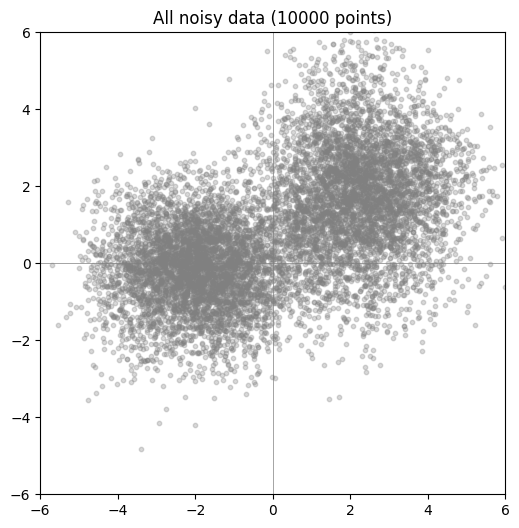

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(all_noisy_data[:, 0], all_noisy_data[:, 1], c="gray", alpha=0.3, s=10)
plt.title("All noisy data (10000 points)")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.show()

## 4. ノイズ後の空間の「特定のピクセル(領域)」とその元データの可視化


In [24]:
def plot_region_and_sources(
    x_center=0.0,
    y_center=0.0,
):
    """
    指定された (x_center, y_center) を中心とした
    幅width, 高さheight の矩形領域に含まれるノイズ後サンプル (noisy_in_pixel) を
    濃い色でプロットし、
    さらにそれらのサンプルが元の空間のどこから来たか (pixel_source_points) を赤色で描画する。

    また、全ノイズ後データ (all_noisy_data) は薄い色で表示する。
    """
    width = 0.5
    height = 0.5
    xmin = x_center - width / 2
    xmax = x_center + width / 2
    ymin = y_center - height / 2
    ymax = y_center + height / 2

    # --- 矩形領域に入るサンプルを抽出 ---
    in_pixel_mask = (
        (all_noisy_data[:, 0] >= xmin)
        & (all_noisy_data[:, 0] < xmax)
        & (all_noisy_data[:, 1] >= ymin)
        & (all_noisy_data[:, 1] < ymax)
    )
    idx_in = np.where(in_pixel_mask)[0]

    # 矩形内にあるノイズ後サンプル
    noisy_in_pixel = all_noisy_data[idx_in]

    # そのノイズ後サンプルの「元データインデックス」と「元座標」
    pixel_sources = all_noisy_source_index[idx_in]
    pixel_source_points = train_data[pixel_sources]

    # --- プロット ---
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1. 全ノイズ後データ(薄い色)
    ax.scatter(
        all_noisy_data[:, 0],
        all_noisy_data[:, 1],
        color="lightgray",
        alpha=0.25,
        s=10,
        label="All noisy data",
    )

    # 2. 矩形に入っているノイズ後データ(濃い色)
    ax.scatter(
        noisy_in_pixel[:, 0],
        noisy_in_pixel[:, 1],
        color="#4895ef",
        alpha=0.3,
        s=10,
        label="Noisy data in region",
    )

    # 3. 全訓練データ(元データ)
    ax.scatter(
        train_data[:, 0],
        train_data[:, 1],
        color="gray",
        alpha=1.0,
        s=20,
        label="All train_data",
    )

    # 4. 矩形内のノイズの元データ点(赤)
    ax.scatter(
        pixel_source_points[:, 0],
        pixel_source_points[:, 1],
        color="#f72585",
        alpha=0.25,
        s=20,
        label="Sources in region",
    )

    # 5. 矩形領域の描画
    rect_x = [xmin, xmax, xmax, xmin, xmin]
    rect_y = [ymin, ymin, ymax, ymax, ymin]
    ax.plot(rect_x, rect_y, color="black", linestyle="--", label="Selected Region")

    ax.set_title(
        f"Noisy region => {len(idx_in)} samples\n"
        f"Red: {len(pixel_source_points)} sources"
    )
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.legend()
    plt.show()


In [25]:
# スライダーの設定
x_center_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description="x_center",
    continuous_update=True,
)
y_center_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description="y_center",
    continuous_update=True,
)

interactive_obj = widgets.interactive(
    plot_region_and_sources,
    x_center=x_center_slider,
    y_center=y_center_slider,
)


In [26]:
display(interactive_obj)

interactive(children=(FloatSlider(value=0.0, description='x_center', max=5.0, min=-5.0), FloatSlider(value=0.0…

一部例示

Center: (0.0, 0.0)


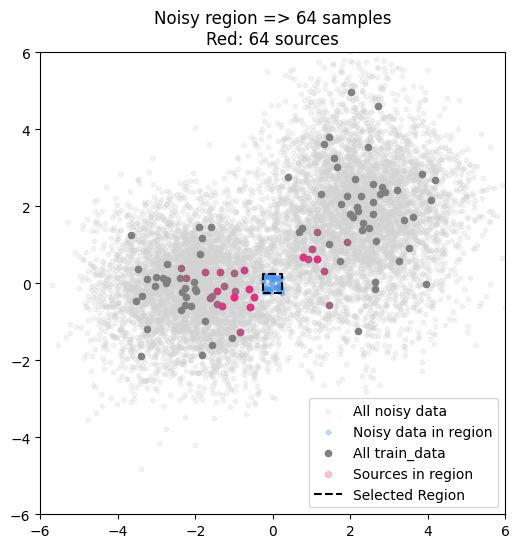

Center: (2.0, 0.0)


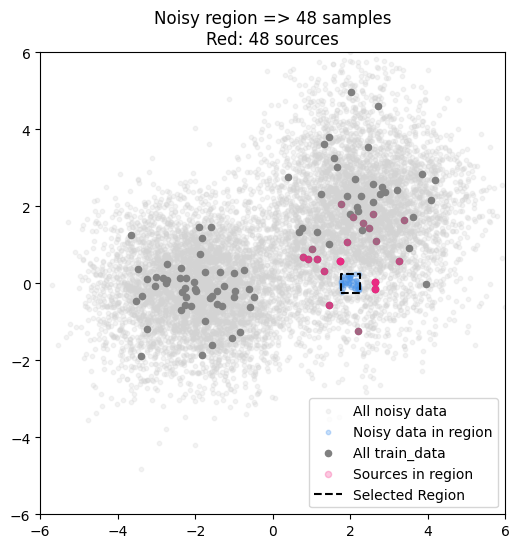

Center: (2.0, -2.0)


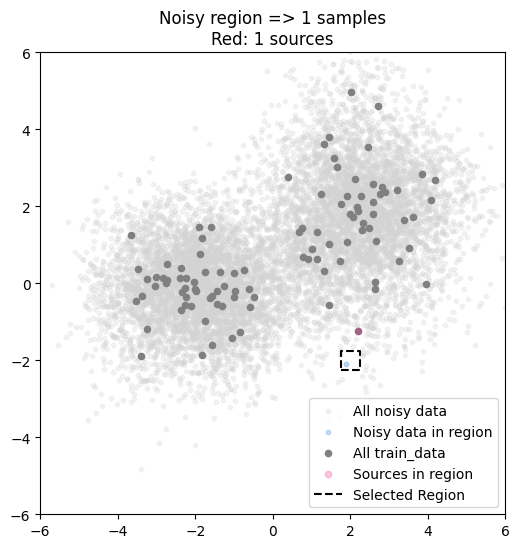

Center: (-2.0, -2.0)


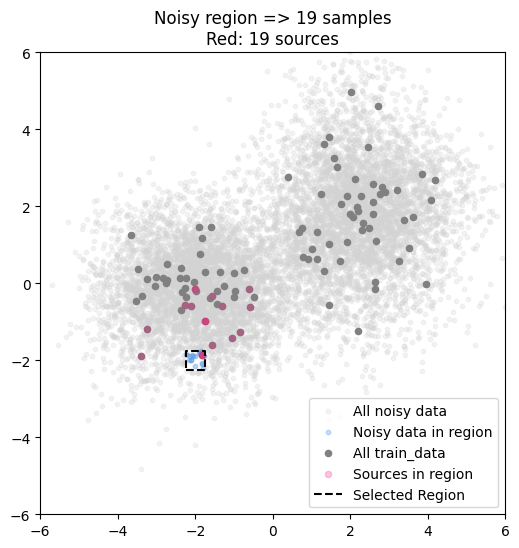

Center: (0.0, 2.0)


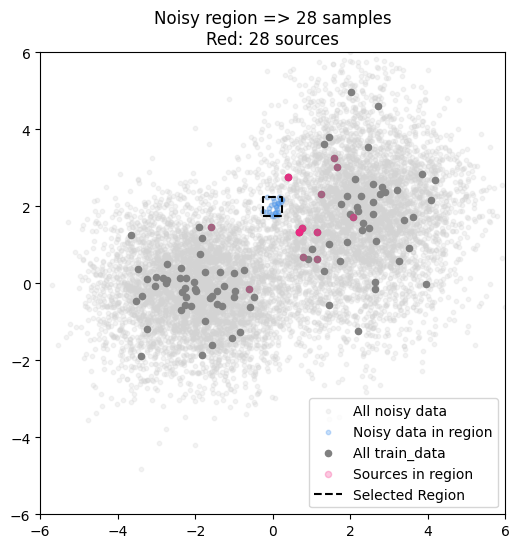

In [27]:
list_center = [
    (0.0, 0.0),
    (2.0, 0.0),
    (2.0, -2.0),
    (-2.0, -2.0),
    (0.0, 2.0),
]
for x_center, y_center in list_center:
    print(f"Center: ({x_center}, {y_center})")
    plot_region_and_sources(x_center, y_center)


# デノイジングスコアマッチングの数式との対応
(注; o1生成. 内容未精査.)
以下では、これまでのノートブックやコードで行っている **「ノイズ後の空間で特定の領域を取り出して、そのサンプルの元の点を可視化する」** という操作と、  
**デノイジングスコアマッチング (Denoising Score Matching, DSM)** における数式的背景の対応を整理します。

---

## 1. デノイジングスコアマッチングの数式的背景

### 1.1 デノイジングの設定

- **元の分布**: 未知の真のデータ分布 $ p_0(\mathbf{x}) $ から、$ \mathbf{x} \in \mathbb{R}^d $ のサンプルが得られる。  
- **ノイズ付加**: そのサンプルにガウスノイズを加える

$$
\tilde{\mathbf{x}} = \mathbf{x} + \boldsymbol{\epsilon}, 
\quad \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}),
$$

とすると、$ \tilde{\mathbf{x}} $ の確率分布は

$$
p(\tilde{\mathbf{x}}) 
= \int p_0(\mathbf{x}) \,\mathcal{N}\bigl(\tilde{\mathbf{x}} \mid \mathbf{x}, \sigma^2 \mathbf{I}\bigr)\,d\mathbf{x}.
$$

- **デノイジング関数**: ある $ \tilde{\mathbf{x}} $ に対して「元の $ \mathbf{x} $ を推定する」写像を $ f_\theta(\tilde{\mathbf{x}}) $ とおく（パラメータ $ \theta $ を持つニューラルネットなど）。

このとき、**デノイジング（平均二乗誤差）**を最小化することが

$$
\min_{\theta}\, \mathbb{E}_{\mathbf{x}, \tilde{\mathbf{x}}}
\bigl\|\mathbf{x} - f_\theta(\tilde{\mathbf{x}})\bigr\|^2
$$

につながり、結果として **$ \tilde{\mathbf{x}} $ を元に戻す方向** を学習することになります。

---

### 1.2 スコアとの対応

- **スコア関数 (Score)**: もとの分布 $ p_0(\mathbf{x}) $ の対数密度勾配

$$
s(\mathbf{x}) = \nabla_{\mathbf{x}}\log p_0(\mathbf{x}).
$$

- **デノイジングスコアマッチング**:  
  「**少しノイズを足したサンプルを元に戻すベクトル**」を学習することで、

$$
s_\theta(\tilde{\mathbf{x}}) 
\approx \nabla_{\tilde{\mathbf{x}}} \log p(\tilde{\mathbf{x}}),
$$

ないし元の空間でのスコア $ \nabla_{\mathbf{x}}\log p_0(\mathbf{x}) $ を近似できる、という理論的結果があります。  
（詳しくは Vincent (2011) や Song & Ermon (2019) 等を参照）

**要点**は、「**ノイズを小さくすると、$ \tilde{\mathbf{x}} - \mathbf{x} $ がスコアの方向に比例する**」という事実で、

$$
\mathbf{x} 
\approx \tilde{\mathbf{x}} - \sigma^2\, s_\theta(\tilde{\mathbf{x}}).
$$

（あるいは「$ \tilde{\mathbf{x}} $ から $ \mathbf{x} $ へ向かうベクトル」は分布の勾配と一致すると言い換えられます）

---

## 2. コードで何をしているか

### 2.1 ノイズ後の空間を「$ \tilde{\mathbf{x}} $-空間」とみなす

コード上で、

1. **$ p_0(\mathbf{x}) $ から 100 サンプル取得** → `train_data`  
2. **各 $ \mathbf{x} $ に対して、ガウスノイズを 100 個** → `all_noisy_data` (合計1万点)  
   - この `all_noisy_data` は $ \tilde{\mathbf{x}} $ のサンプル  
   - どの $ \mathbf{x} $ から生まれたかを `all_noisy_source_index` で保持  
3. ノートブック上では、**ノイズ後の空間 ($ \tilde{\mathbf{x}} $-空間)** で「どこに $ \tilde{\mathbf{x}} $ が落ちたか」を見ることを目的にしている。

つまり、**あるノイズ後の点 $ \tilde{\mathbf{x}} $** に対して、  
「それがどの元サンプル $ \mathbf{x} $ から来たか（あるいは来た可能性が高いか）」  
を抽出・可視化しているわけです。

---

### 2.2 矩形領域を指定

- コードの中で「ノイズ後空間のある矩形領域 $ [x_{\min}, x_{\max}] \times [y_{\min}, y_{\max}] $」を指定し、そこに含まれる $ \tilde{\mathbf{x}} $ を抽出→可視化しました。  
- つまり「$ \tilde{\mathbf{x}} $-空間の中で、ある領域を切り取ると、その領域に属するサンプルは**元の空間($ \mathbf{x} $-空間)のどのあたり**から来ているのか？」を散布図やKDEで示しています。

---

## 3. 「元の点を可視化する」= 事後分布イメージ

これは、確率論的に言うと**事後分布** $ p(\mathbf{x} \mid \tilde{\mathbf{x}}) $ を可視化する行為に対応しています。

- **ベイズ則**:

$$
p(\mathbf{x} \mid \tilde{\mathbf{x}})
\;\propto\;
p_0(\mathbf{x})
\,\mathcal{N}\bigl(\tilde{\mathbf{x}} \mid \mathbf{x},\sigma^2 \mathbf{I}\bigr).
$$

- 実際のコードでは「元の $ \mathbf{x} $ は有限個のサンプル（`train_data`）しかなく、それぞれにノイズを足した $ \tilde{\mathbf{x}} $ が 1万点ある」という離散的な近似になっています。  
- **「$ \tilde{\mathbf{x}} $ がここに落ちたとき、どの $ \mathbf{x} $ から来ていることが多いか？」** を可視化したのが、本コードで行う「矩形領域内の $ \tilde{\mathbf{x}} $ の元$ \mathbf{x} $ をハイライトする」操作です。

---

## 4. デノイジングとスコアを結びつける直感

1. **少しだけノイズを足す (小さい $ \sigma $)** → $ \tilde{\mathbf{x}} \approx \mathbf{x} $.  
2. 「$ \tilde{\mathbf{x}} $ から見て『どの方向に$ \mathbf{x} $ が分布しているか』」は、  
   すなわち「**元分布 $ p_0(\mathbf{x}) $ の高密度方向**」に相当。  
3. **ネットワークに「$ \tilde{\mathbf{x}} $ を元に戻すベクトル」を学ばせる**と、結果的に**分布の勾配** $ \nabla_{\mathbf{x}} \log p_0(\mathbf{x}) $ を推定できる。  
   - デノイジング: $ \tilde{\mathbf{x}} \mapsto \mathbf{x} $  
   - スコア: $ \nabla_{\mathbf{x}} \log p_0(\mathbf{x}) $  
   - 小さいノイズでのデノイジング課題を「スコア推定」と同値視できるのがデノイジングスコアマッチングの核。

---

### 図示例

コード中で「ノイズ後の点が特定の矩形領域にある」としたとき、  
そのサンプルの**元の点 ($ \mathbf{x} $)** を集めて赤く表示すると、  
「**($ \tilde{\mathbf{x}} $-空間で) このあたりに$ \tilde{\mathbf{x}} $ が観測されたとき、$ \mathbf{x} $ はこのあたりだった可能性が高い**」  
ことが分かります。

これを**すべての $ \tilde{\mathbf{x}} $ に対して推定**する作業を「学習（デノイジング関数またはスコア関数の学習）」という形で行うと、

- 実際には $ \tilde{\mathbf{x}} $ から $ \mathbf{x} $ を直接出力できるようになる (= デノイジング)  
- それが結果的に「スコア ( $ \nabla_{\mathbf{x}}\log p_0(\mathbf{x}) $ )」を学ぶことと本質的に同じになる ( = スコアマッチング)  

---

## 5. まとめ

1. **ノートブックやコード**でやっていることは、  
   - ノイズ後空間 ($ \tilde{\mathbf{x}} $-空間) で特定の領域を選び、そこに属するサンプルの「元 $ \mathbf{x} $」を可視化している。  
   - これは「$ \tilde{\mathbf{x}} $ が特定領域に来たときの、$ \mathbf{x} $ 分布 (事後分布)」を**離散的に**眺めるイメージ。

2. **デノイジングスコアマッチングの数式との対応**  
   - 「$ \tilde{\mathbf{x}} = \mathbf{x} + \boldsymbol{\epsilon} $」というノイズ付加モデルと、「$ \tilde{\mathbf{x}} $ から $ \mathbf{x} $ を推定するデノイジング」を考えると、**スコア (分布勾配) を推定することに等しい** という理論がある。  
   - コードは、その可視化（小さいノイズなら「$ \tilde{\mathbf{x}} $ の周りのどこに $ \mathbf{x} $ が多いか」が分布の勾配と近い）を行っている例である。

3. **結論**: デノイジング(少量ノイズ) ≒ スコア (対数密度勾配) の推定  
   - デノイジングタスクを学習すると、確率密度の勾配ベクトル場を得ることと本質的に同じ。
